In [99]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import xarray as xr
import pandas as pd
import pytz
from datetime import datetime as dt,timedelta
import sys,os,glob
import IPython
from matplotlib import cm

import cartopy.crs as ccrs

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

In [117]:
workdir = os.getcwd()
rootdir = os.path.dirname(workdir)
figdir = os.path.join(rootdir,'figures','exploreRadiativeCoolingPeak')
if not os.path.exists(figdir): os.makedirs(figdir)

In [118]:
indir_sonde_qrad = '/Users/bfildier/Data/EUREC4A/merged/radiative_profiles'

In [119]:
date = '20200126'
day = dt.strptime(date,'%Y%m%d')

lat_box = 11,16
lon_box = -60,-52

In [4]:
print('load rad profiles')
radprf = xr.open_dataset(os.path.join(indir_sonde_qrad,'rad_profiles.nc'))

load rad profiles


In [5]:
print('convert times to datetime objects')
timestamps = [int(lt/1e9) for lt in radprf.launch_time.values]
times = [dt.fromtimestamp(ts)-timedelta(hours=1) for ts in timestamps] # removing 1 hour apparently necessary to match the original sonde time
# double check that (t-dt(1970,1,1)).total_seconds() gives the same time stamp
radprf = radprf.assign(launch_time=times) # reassign to object

convert times to datetime objects


In [6]:
print('removing 1 hour apparently necessary to match the original sonde time')
sondes = xr.open_dataset('/Users/bfildier/Data/EUREC4A/merged/sondes/all_sondes.nc')
sondes.launch_time

removing 1 hour apparently necessary to match the original sonde time


<xarray.DataArray 'launch_time' (launch_time: 2522)>
array(['2020-01-19T16:55:14.000000000', '2020-01-19T17:21:54.000000000',
       '2020-01-19T17:33:12.000000000', ..., '2020-02-16T00:18:14.000000000',
       '2020-02-16T02:43:46.000000000', '2020-02-16T04:14:33.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * launch_time  (launch_time) datetime64[ns] 2020-01-19T16:55:14 ... 2020-02-16T04:14:33

# Show profiles for one day

## Select profiles

In [7]:
print('choose profiles for that day that start at bottom')
data_day = radprf.where(radprf.z_min<=50,drop=True).sel(launch_time=date)

choose profiles for that day that start at bottom


<xarray.DataArray 'longitude' (launch_time: 3)>
array([-59.42916599, -57.25125966, -58.34474472])
Coordinates:
    lay          int32 1
    col          int32 1
    zlay         int64 55
  * launch_time  (launch_time) datetime64[ns] 2020-01-26T06:45:08 ... 2020-01-26T06:59:11
    play         (launch_time) float64 1.008e+05 1.009e+05 1.006e+05 <xarray.DataArray 'latitude' (launch_time: 3)>
array([13.16245306, 12.71318827,  9.72310563])
Coordinates:
    lay          int32 1
    col          int32 1
    zlay         int64 55
  * launch_time  (launch_time) datetime64[ns] 2020-01-26T06:45:08 ... 2020-01-26T06:59:11
    play         (launch_time) float64 1.008e+05 1.009e+05 1.006e+05


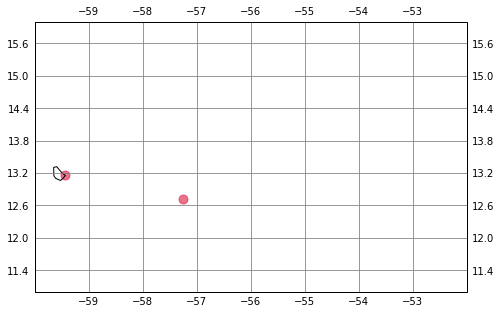

In [86]:
i_h = 6

time_init = dt(2020,1,26)
timedelta(hours=i_h)

mask_hour = np.logical_and(times > time_init+timedelta(hours=i_h), times <= time_init+timedelta(hours=i_h+1))
data_hour = data_day.sel(launch_time=mask_hour)

# data_hour.latitude.dropna(dim='zlay')[:,0]

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(np.diff(lon_box),np.diff(lat_box)))

ax.coastlines(resolution='50m')
ax.set_extent([*lon_box,*lat_box])
gl = ax.gridlines(color='Grey',draw_labels=True)
# gl.xlabel_style = {'size': 16}
# gl.ylabel_style = {'size': 16}

x_s = data_hour.longitude.dropna(dim='zlay')[:,0]
y_s = data_hour.latitude.dropna(dim='zlay')[:,0]
print(x_s,y_s)
m = ax.scatter(x_s,y_s,marker='o',color='crimson',alpha=0.6,s=80,label='Dropsondes')


In [137]:
cols

[(0, 0, 127, 255), (124, 255, 121, 255), (127, 0, 0, 255)]

Text(0, 0.5, 'Latitude')

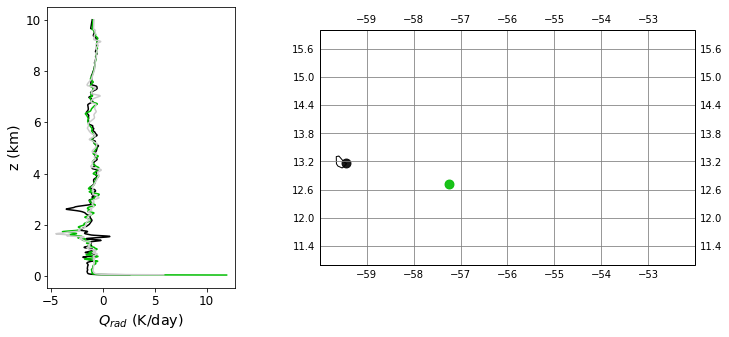

In [143]:
print('example for given hour slice')

i_h = 6

time_init = dt(2020,1,26)
timedelta(hours=i_h)

mask_hour = np.logical_and(times > time_init+timedelta(hours=i_h), times <= time_init+timedelta(hours=i_h+1))
data_hour = data_day.sel(launch_time=mask_hour)

cols = [plt.cm.nipy_spectral(x) for x in np.linspace(0,1,data_hour.dims['launch_time'])]

fig = plt.figure(figsize=(np.diff(lon_box)*3/2,np.diff(lat_box)))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

## (a) Q_rad profiles

ax = plt.subplot(gs[0])
for i_lt in range(data_hour.dims['launch_time']):
    ax.plot(data_day.q_rad[i_lt],data_day.zlay/1e3,alpha=1,c=cols[i_lt])
    
ax.set_xlabel(r'$Q_{rad}$ (K/day)')
ax.set_ylabel(r'z (km)')

## (b) sonde location
    
ax = plt.subplot(gs[1],projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.set_extent([*lon_box,*lat_box])
gl = ax.gridlines(color='Grey',draw_labels=True)
# gl.xlabel_style = {'size': 16}
# gl.ylabel_style = {'size': 16}

x_s = data_hour.longitude.dropna(dim='zlay')[:,0]
y_s = data_hour.latitude.dropna(dim='zlay')[:,0]
col = plt.rcParams['axes.prop_cycle'].by_key()['color'][:x_s.size]

for i_s in range(x_s.size):
    
    ax.scatter(x_s[i_s],y_s[i_s],marker='o',color=cols[i_s],alpha=0.9,s=80,label='Dropsondes')

ax.set_xlabel(r'Longitude')
ax.set_ylabel(r'Latitude')


In [145]:
print("display for all hours on that day")

times = np.array([dt.strptime(str(d)[:19],'%Y-%m-%dT%H:%M:%S') for d in data_day.launch_time.values])

for i_h in range(24):
    
    print(i_h)
    
    time_init = dt(2020,1,26)
    time_current = time_init+timedelta(hours=i_h)
    time_label = time_current.strftime("%Y%m%d_%H")
    
    mask_hour = np.logical_and(times > time_init+timedelta(hours=i_h), times <= time_init+timedelta(hours=i_h+1))
    data_hour = data_day.sel(launch_time=mask_hour)
    
    ###--- Plot ---###
    
    cols = [plt.cm.nipy_spectral(x) for x in np.linspace(0,1,data_hour.dims['launch_time'])]
    
    fig = plt.figure(figsize=(np.diff(lon_box)*3/2,np.diff(lat_box))) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

    ## (a) Q_rad profiles

    ax = plt.subplot(gs[0])
    for i_lt in range(data_hour.dims['launch_time']):
        ax.plot(data_day.q_rad[i_lt],data_day.zlay/1e3,alpha=1,c=cols[i_lt])

    ax.set_xlabel(r'$Q_{rad}$ (K/day)')
    ax.set_ylabel(r'z (km)')

    ## (b) sonde location

    ax = plt.subplot(gs[1],projection=ccrs.PlateCarree())
    ax.coastlines(resolution='50m')
    ax.set_extent([*lon_box,*lat_box])
    gl = ax.gridlines(color='Grey',draw_labels=True)
    # gl.xlabel_style = {'size': 16}
    # gl.ylabel_style = {'size': 16}

    x_s = data_hour.longitude.dropna(dim='zlay')[:,0]
    y_s = data_hour.latitude.dropna(dim='zlay')[:,0]
    col = plt.rcParams['axes.prop_cycle'].by_key()['color'][:x_s.size]

    for i_s in range(x_s.size):

        ax.scatter(x_s[i_s],y_s[i_s],marker='o',color=cols[i_s],alpha=0.9,s=80,label='Dropsondes')

    ax.set_xlabel(r'Longitude')
    ax.set_ylabel(r'Latitude')

    plt.savefig(os.path.join(figdir,'qrad_profile_and_position_%s.pdf'%time_label),bbox_inches='tight')
#     plt.show()
    plt.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


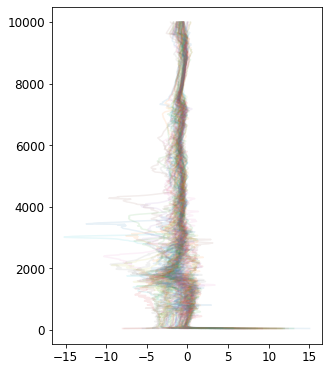

In [156]:
fig, ax = plt.subplots(figsize=(5,6))
for i_lt in range(data_day.dims['launch_time']):
    ax.plot(data_day.q_rad[i_lt],data_day.zlay,alpha=0.1)